# Requirement 2: User Movie Recommender (Recommend movies for userIDs)

## 1. Business Understanding (Handled in IS 401)

## 2. Data Understanding

In [33]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import random
import sqlite3

# Load the datasets
def load_data(users_path="movies_users.csv",
              titles_path="movies_titles.csv",
              ratings_path="movies_ratings.csv"):
    try:
        df_users = pd.read_csv(users_path)
        df_titles = pd.read_csv(titles_path)
        df_ratings = pd.read_csv(ratings_path)
        return df_users, df_titles, df_ratings
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Explore the datasets
def explore_data(df_users, df_titles, df_ratings):
    print("--- User Data Info ---")
    # Use io.StringIO to capture print output of info()
    buffer = io.StringIO()
    df_users.info(buf=buffer)
    print(buffer.getvalue())

    print("\n--- Title Data Info ---")
    buffer = io.StringIO()
    df_titles.info(buf=buffer)
    print(buffer.getvalue())

    print("\n--- Rating Data Info ---")
    buffer = io.StringIO()
    df_ratings.info(buf=buffer)
    print(buffer.getvalue())

    # Ratings distribution
    plt.figure(figsize=(6, 4))
    df_ratings['rating'].hist(bins=5)
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()

    # Number of ratings per user
    plt.figure(figsize=(6, 4))
    ratings_per_user = df_ratings['user_id'].value_counts()
    sns.histplot(ratings_per_user, bins=30)
    plt.title("Ratings Per User")
    plt.xlabel("Number of Ratings")
    plt.ylabel("Users")
    plt.show()

    # Genre Distribution (based on one-hot encoded genres)
    # Ensure only numeric columns intended as genres are summed
    genre_columns = df_titles.select_dtypes(include=['int64', 'float64']).columns
    # Exclude potentially non-genre numeric columns if necessary, e.g., 'release_year', 'zip' if they were present
    genre_columns = [col for col in genre_columns if col not in ['user_id', 'age', 'Netflix', 'Amazon Prime', 'Disney+', 'Paramount+', 'Max', 'Hulu', 'Apple TV+', 'Peacock', 'zip', 'release_year', 'user_rating']] # Add others if needed
    # We assume columns from index 10 onwards are genres based on original code
    genre_sums = df_titles.iloc[:, 10:].sum().sort_values(ascending=False)

    plt.figure(figsize=(10, 4))
    genre_sums.plot(kind='bar', title="Genre Distribution")
    plt.xlabel("Genre")
    plt.ylabel("Number of Shows")
    plt.xticks(rotation=90, ha='right') # Rotate labels for better readability
    plt.tight_layout() # Adjust layout
    plt.show()

    # Missing values table for titles
    print("\n--- Missing Values in Titles ---")
    print(df_titles.isnull().sum().sort_values(ascending=False))


#### Interpretation of Data Understanding

The dataset contains 200 unique users, 8508 unique shows, and 2147 ratings. Ratings are mostly between 3 and 5, with a fairly even spread across those values. Most users provided 11 ratings, with smaller clusters giving 9 or 10, suggesting consistent user activity and strong support for collaborative filtering.

The genre distribution across shows is diverse, with Dramas, Comedies, and International Movies being the most common categories.

Several content columns, including director, cast, and country, have missing values and will require attention during data preparation.

## 3. Data Preparation

In [34]:
def preprocess(df_users, df_titles, df_ratings):
    # Rename the rating column in df_ratings to 'user_rating' for consistency
    df_ratings.rename(columns={'rating': 'user_rating'}, inplace=True)
    
    # Merge the ratings, titles, and users datasets into a single dataframe
    df = df_ratings.merge(df_titles, on='show_id').merge(df_users, on='user_id')
    
    # Fill missing values in the 'description' and 'director' columns with empty strings
    # Convert these columns to lowercase strings for uniformity
    df['description'] = df['description'].fillna('').astype(str).str.strip().str.lower()
    df['director'] = df['director'].fillna('').astype(str).str.strip().str.lower()
    
    # Convert the 'user_rating' column to numeric, coercing invalid values to NaN
    df['user_rating'] = pd.to_numeric(df['user_rating'], errors='coerce')
    
    # Drop rows where 'user_rating' is NaN (invalid or missing ratings)
    df.dropna(subset=['user_rating'], inplace=True)
    
    # Return the cleaned and merged dataframe
    return df

## 4. Modeling and Evaluation

In [35]:
def build_collaborative_model(df):
    # Create a user-item matrix where each row is a user and each column is a show
    user_item_matrix = df.pivot_table(index='user_id', columns='show_id', values='user_rating').fillna(0)
    X = user_item_matrix.T.values  # Transpose matrix for item-based collaborative filtering
    
    # Create mappings between show IDs and their indices in the matrix
    mapper = {sid: idx for idx, sid in enumerate(user_item_matrix.columns)}
    inv_mapper = {idx: sid for sid, idx in mapper.items()}

    # Use k-nearest neighbors to find similar shows based on user ratings
    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(X)

    # Generate recommendations for each show
    recs = {}
    for sid in mapper:
        idx = mapper[sid]
        _, indices = model.kneighbors([X[idx]])
        # Store the top 5 most similar shows (excluding itself)
        recs[sid] = [inv_mapper[i] for i in indices[0] if i != idx][:5]

    # Convert recommendations dictionary to a dataframe
    return pd.DataFrame.from_dict(recs, orient='index').rename_axis('show_id').reset_index().rename(columns={i: f"rec_{i+1}" for i in range(5)})

def build_content_model(df_titles):
    # Prepare text data by combining description and director
    df_titles['description'] = df_titles['description'].fillna('').astype(str).str.strip().str.lower()
    df_titles['director'] = df_titles['director'].fillna('').astype(str).str.strip().str.lower()
    df_titles['combined'] = df_titles['description'] + " " + df_titles['director']

    # Create TF-IDF vectors from the combined text
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df_titles['combined'])

    # Use k-nearest neighbors to find similar shows based on content
    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    model.fit(tfidf_matrix)

    # Generate content-based recommendations for each show
    recs = {}
    for idx, sid in enumerate(df_titles['show_id']):
        _, indices = model.kneighbors(tfidf_matrix[idx])
        # Store the top 5 most similar shows (excluding itself)
        recs[sid] = [df_titles['show_id'].iloc[i] for i in indices[0] if i != idx][:5]

    # Convert recommendations dictionary to a dataframe
    return pd.DataFrame.from_dict(recs, orient='index').rename_axis('show_id').reset_index().rename(columns={i: f"rec_{i+1}" for i in range(5)})

def combine_models(df_collab, df_content):
    # Convert content-based recommendations to long format
    content_long = df_content.melt(id_vars='show_id', value_name='recommended_show')
    content_long['rank_content'] = content_long.groupby('show_id').cumcount() + 1

    # Convert collaborative recommendations to long format
    collab_long = df_collab.melt(id_vars='show_id', value_name='recommended_show')
    collab_long['rank_collab'] = collab_long.groupby('show_id').cumcount() + 1

    # Merge both recommendation types
    hybrid = pd.merge(content_long, collab_long, on=['show_id', 'recommended_show'], how='outer')
    # Replace NaN ranks with a high value (100) to penalize missing recommendations
    hybrid['rank_content'] = hybrid['rank_content'].fillna(100)
    hybrid['rank_collab'] = hybrid['rank_collab'].fillna(100)
    # Calculate combined rank (lower is better)
    hybrid['combined_rank'] = hybrid['rank_content'] + hybrid['rank_collab']

    # Get the top 5 recommendations per show based on combined rank
    hybrid_top = hybrid.sort_values(['show_id', 'combined_rank']).groupby('show_id').head(5)
    final = hybrid_top.groupby('show_id')['recommended_show'].apply(list).reset_index()
    # Convert list to separate columns
    final[[f"rec_{i+1}" for i in range(5)]] = pd.DataFrame(final['recommended_show'].tolist(), index=final.index)
    return final.drop(columns='recommended_show')


def build_user_recommendations(df, df_titles, df_ratings, df_hybrid_final):
    # Get the set of shows each user has already rated
    rated_by_user = df.groupby('user_id')['show_id'].apply(set)
    
    # Create various candidate recommendation pools
    top_default_recs = df['show_id'].value_counts().head(50).index.tolist()  # Most popular shows
    top_tv = df[df['type'] == 'TV Show']['show_id'].value_counts().head(50).index.tolist()  # Most popular TV shows
    top_movie = df[df['type'] == 'Movie']['show_id'].value_counts().head(50).index.tolist()  # Most popular movies
    
    # Find niche content (shows not rated by anyone)
    all_ids = set(df_titles['show_id'].unique())
    rated_ids = set(df_ratings['show_id'].unique())
    niche_pool = list(all_ids - rated_ids)
    top_niche = df_titles[df_titles['show_id'].isin(niche_pool)]['show_id'].head(50).tolist()

    # Create a mapping for genre data
    genre_map = df_titles.set_index('show_id')
    genre_cols = [col for col in df_titles.columns if df_titles[col].dropna().isin([0,1]).all() and col not in ['show_id']]

    # Helper function to build recommendation lists
    def pad_list(primary, backup, exclude, seen):
        recs = []
        for r in primary:
            if r not in exclude:
                recs.append(r)
                exclude.add(r)
            if len(recs) == 10:
                return recs
        for b in backup:
            if b not in exclude and b not in seen:
                recs.append(b)
                exclude.add(b)
            if len(recs) == 10:
                break
        return recs

    # Generate personalized recommendations for each user
    def get_user_rec(uid):
        seen = rated_by_user[uid]  # Shows this user has seen
        exclude = set()  # Track shows we've already recommended to avoid duplicates

        # Get hybrid recommendations based on shows this user has seen
        hybrid_recs = []
        for sid in seen:
            row = df_hybrid_final[df_hybrid_final['show_id'] == sid]
            if not row.empty:
                hybrid_recs += row.iloc[0][[f"rec_{i+1}" for i in range(5)]].dropna().tolist()
        hybrid_recs = [r for r in dict.fromkeys(hybrid_recs) if r not in seen]  # Remove duplicates and seen shows

        # Generate different recommendation categories
        top10 = pad_list(hybrid_recs, top_default_recs, exclude, seen)  # General recommendations
        tv10 = pad_list([r for r in hybrid_recs if genre_map.loc[r]['type'] == 'TV Show'], top_tv, exclude, seen)  # TV show recommendations
        movie10 = pad_list([r for r in hybrid_recs if genre_map.loc[r]['type'] == 'Movie'], top_movie, exclude, seen)  # Movie recommendations

        # Find user's preferred genres based on what they've watched
        seen_genres = genre_map.loc[list(seen)].dropna(axis=1, how='all')
        genre_sums = seen_genres[genre_cols].sum().sort_values(ascending=False)
        preferred = genre_sums[genre_sums > 0].index.tolist()

        # Generate niche recommendations that match user's genre preferences
        niche_filtered = df_titles[df_titles['show_id'].isin(niche_pool)]
        if preferred:
            niche_filtered = niche_filtered[niche_filtered[preferred].sum(axis=1) > 0]
        candidates = niche_filtered['show_id'].tolist()
        random.shuffle(candidates)  # Add randomness to niche recommendations
        niche10 = pad_list(candidates, top_niche, exclude, seen)

        # Return user ID and all recommendation categories
        return [uid] + top10 + tv10 + movie10 + niche10

    # Generate recommendations for all users
    rows = [get_user_rec(uid) for uid in df['user_id'].unique()]
    # Define column names for the output dataframe
    cols = ['user_id'] + [f"rec_{i+1}" for i in range(10)] + [f"tv_rec_{i+1}" for i in range(10)] + [f"movie_rec_{i+1}" for i in range(10)] + [f"niche_rec_{i+1}" for i in range(10)]
    return pd.DataFrame(rows, columns=cols)

## 5. Deployment

--- User Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       200 non-null    int64 
 1   name          200 non-null    object
 2   phone         200 non-null    object
 3   email         200 non-null    object
 4   age           200 non-null    int64 
 5   gender        200 non-null    object
 6   Netflix       200 non-null    int64 
 7   Amazon Prime  200 non-null    int64 
 8   Disney+       200 non-null    int64 
 9   Paramount+    200 non-null    int64 
 10  Max           200 non-null    int64 
 11  Hulu          200 non-null    int64 
 12  Apple TV+     200 non-null    int64 
 13  Peacock       200 non-null    int64 
 14  city          200 non-null    object
 15  state         200 non-null    object
 16  zip           200 non-null    int64 
dtypes: int64(11), object(6)
memory usage: 26.7+ KB


--- Title Data Info 

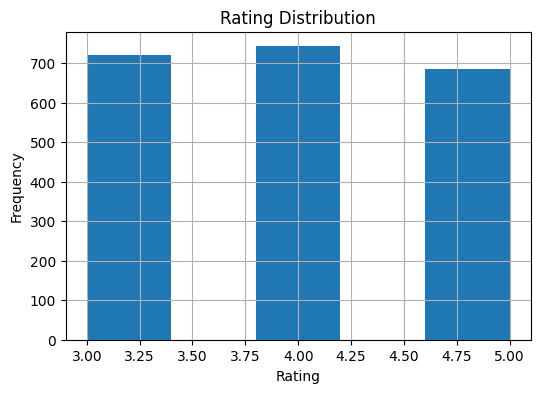

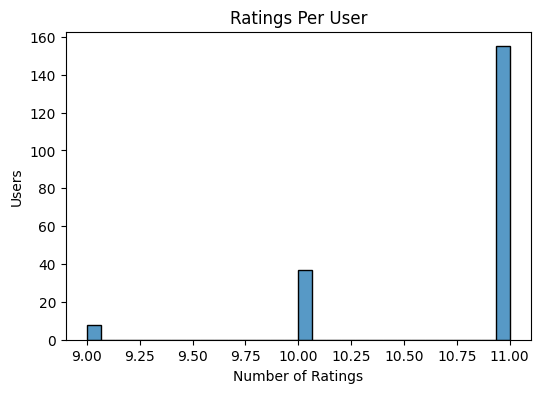

C:\Users\spenc\AppData\Local\Temp\ipykernel_60808\624687282.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() # Adjust layout


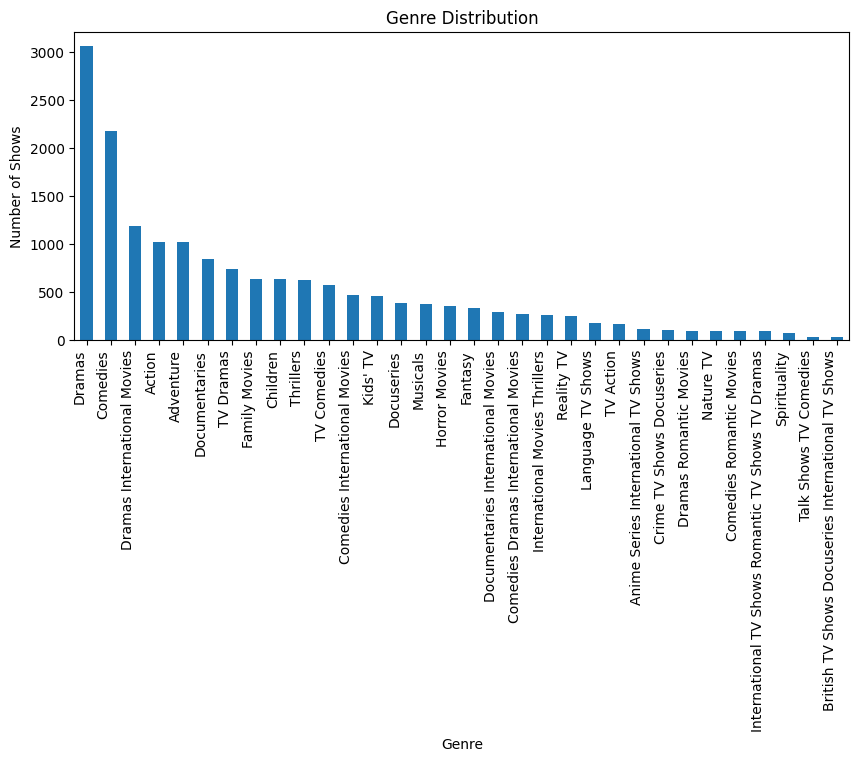


--- Missing Values in Titles ---
director                                              2114
country                                                814
cast                                                   119
rating                                                   4
duration                                                 1
show_id                                                  0
Musicals                                                 0
Family Movies                                            0
Fantasy                                                  0
Horror Movies                                            0
International Movies Thrillers                           0
International TV Shows Romantic TV Shows TV Dramas       0
Kids' TV                                                 0
Language TV Shows                                        0
Spirituality                                             0
Nature TV                                                0
Reality TV            

In [36]:
def export_to_sqlite(df_user_recs, db_name="user_recommendations.db"):
    # Connect to SQLite database (or create it if it doesn't exist)
    conn = sqlite3.connect(db_name)
    
    # Save the user recommendations DataFrame to a table in the database
    df_user_recs.to_sql("user_recommendations", conn, if_exists="replace", index=False)
    
    # Commit changes and close the connection
    conn.commit()
    conn.close()
    
    # Print confirmation message
    print("✅ Finished! user_recommendations.db saved.")

# Load the datasets (users, titles, and ratings)
df_users, df_titles, df_ratings = load_data()

# Explore the datasets to understand their structure and content
explore_data(df_users, df_titles, df_ratings)

# Preprocess and clean the data (merge datasets, handle missing values, etc.)
df = preprocess(df_users, df_titles, df_ratings)

# Build collaborative filtering model and generate recommendations
df_collab = build_collaborative_model(df)

# Build content-based filtering model and generate recommendations
df_content = build_content_model(df_titles)

# Combine collaborative and content-based recommendations into a hybrid model
df_hybrid_final = combine_models(df_collab, df_content)

# Generate personalized user recommendations based on the hybrid model
df_user_recs = build_user_recommendations(df, df_titles, df_ratings, df_hybrid_final)

# Export the user recommendations to an SQLite database
export_to_sqlite(df_user_recs)

## 6. Automation

All major logic is wrapped in functions.

## 7. Documentation

This notebook uses clean, modular code, follows CRISP-DM methodology, and includes comments and markdown for clarity.